<a href="https://colab.research.google.com/github/ray-hsiehjy/mammogram_masses/blob/master/Mammogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-verbose https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data
!pip install -q shap

2019-10-10 19:40:43 URL:https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data [13450/13450] -> "mammographic_masses.data" [1]
     |████████████████████████████████| 245kB 2.9MB/s 


# Mammographic mass dataset from [UCI repository](https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

## Question
- What are the most helpful features assisting differentiation of benign and malignant masses?

## Attribute Information

- 6 Attributes in total 
    - 1 goal field, 1 non-predictive, 4 predictive attributes

- BI-RADS assessment: 1 to 5 (**ordinal**, non-predictive!)
- Age: patient's age in years (**integer**)
- Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (**nominal**)
- Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (**nominal**)
- Density: mass density high=1 iso=2 low=3 fat-containing=4 (**ordinal**)
- Severity: benign=0 or malignant=1 (**binominal**, goal field!)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import shap

%matplotlib inline

In [3]:
# read in data from csv
df = pd.read_csv("/content/mammographic_masses.data", header=None, names=["BI-RADS", "Age", "Shape", "Margin", "Density", "Label"])
# handling missing data "?" with NaN
df.replace("?", np.nan, inplace=True)
# will drop ~14% of samples
df.dropna(axis=0, inplace=True)
# convert everything to int
df = df.astype("int")
df.head()

,BI-RADS,Age,Shape,Margin,Density,Label
0,5,67,3,5,3,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
8,5,57,1,5,3,1
10,5,76,1,4,3,1


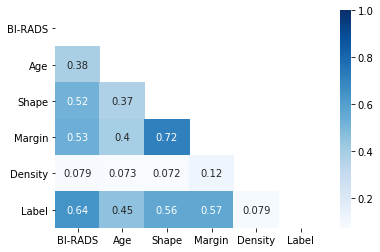

In [4]:
# quick look at correlation between columns
corr = df.corr(method="spearman")
# there is no single column that dominating
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, cmap="Blues", mask=mask)

In [5]:
# convert nominal feature columns to target labels

nominal_features = ["Shape", "Margin"]

hashes = [
          # Shape
          {1:"round", 2:"oval", 3:"lobular", 4:"irregular"},
          # Margin
          {1:"circumscribed", 2:"microlobulated", 3:"obscured", 4:"ill-defined", 5:"spiculated"},
          ]

for feature, h in zip(nominal_features, hashes):
    df[feature].replace(h, inplace=True)

df.head()

,BI-RADS,Age,Shape,Margin,Density,Label
0,5,67,lobular,spiculated,3,1
2,5,58,irregular,spiculated,3,1
3,4,28,round,circumscribed,3,0
8,5,57,round,spiculated,3,1
10,5,76,round,ill-defined,3,1


## Split train_test data

In [6]:
# feature data
X = pd.get_dummies(df.iloc[:, :-1]) 

#Target label
y = df.iloc[:, -1]

train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.1, random_state=41
)

print(f"train_X shape {train_X.shape}")
print(f"test_X shape {test_X.shape}")
print(f"train_y shape {train_y.shape}")
print(f"test_y shape {test_y.shape}")


train_X shape (747, 12)
test_X shape (83, 12)
train_y shape (747,)
test_y shape (83,)


# Random Forest Classifier

In [7]:
# initiate a classifier
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    class_weight="balanced",
    bootstrap=True,
    n_jobs=5,
    random_state=0
    )
# fit with training data
rf_clf.fit(train_X, train_y)
acc = rf_clf.score(train_X, train_y)
print(f"Random forest accuracy on training set = {acc:.3f}")

Random forest accuracy on training set = 0.865


## Feature importance
- BI-RADS has the highest impact on prediction, which makes total sense. BIRADS is determined by radiologist after looking at mammographic images. 
- However, BIRADS along is not sufficient to determine the outcome accurately. 
- SHAP value analysis can provide more insight on how other features affect predicitons.

<BarContainer object of 12 artists>

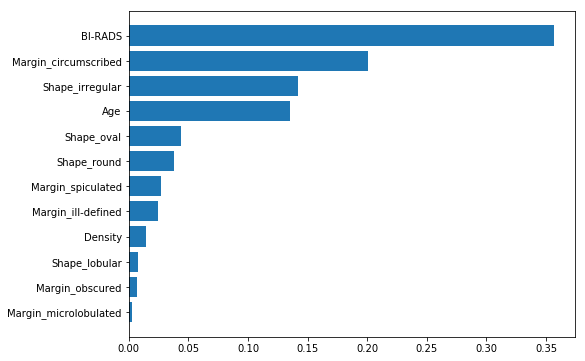

In [8]:
# look at feature importances relative to one and another
importance = rf_clf.feature_importances_
importance = pd.Series(importance, index=train_X.columns).sort_values()
plt.figure(figsize=(8,6))
plt.barh(importance.index, importance)

## Confusion Matrix
- The random forest classifier is doing fairly good. 
- For malignant masses, it is more important to get higher recall than precision during the trade-off, because it is more detrimental to misclassify a malegnant mass than misclassify a benign one. 

              precision    recall  f1-score   support

      benign       0.85      0.77      0.81        44
   malignant       0.77      0.85      0.80        39

    accuracy                           0.81        83
   macro avg       0.81      0.81      0.81        83
weighted avg       0.81      0.81      0.81        83



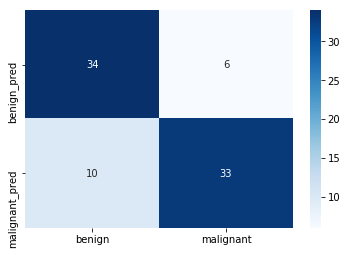

In [9]:
# confusion matrix
rf_pred = rf_clf.predict(test_X)
confusion = confusion_matrix(test_y, rf_pred)
confusion = pd.DataFrame(confusion.T, index=["benign_pred", "malignant_pred"], columns=["benign", "malignant"])
sns.heatmap(confusion, annot=True, cmap="Blues")

report = classification_report(test_y, rf_pred, labels=[0, 1], target_names=["benign", "malignant"])
print(report)

## ROC curve and AUC
- ROC curve shows the relationship between false positive rate and true positive rate
- AUC estimates how good the curve is performing (this is useful when comparing multiple curves. Here there is only one)
- AUC of 0.91 is very good, as it is very close to 1 (100% correct)

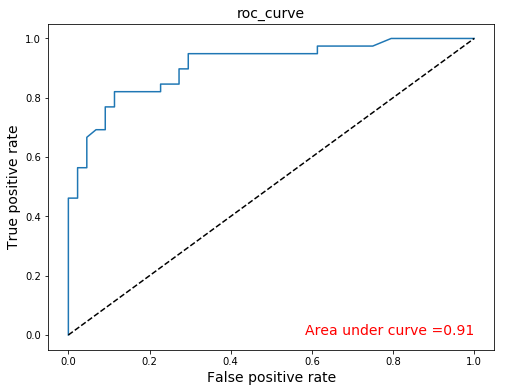

In [10]:
# prob of being malignant for every sample
rf_pred_prob = rf_clf.predict_proba(test_X)[:, 1]

fpr, tpr, thresholds = roc_curve(test_y, rf_pred_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.plot((0,1), (0,1), linestyle="--", color="k")
plt.xlabel("False positive rate", size=14)
plt.ylabel("True positive rate", size=14)
plt.title("roc_curve", size=14)
plt.text(1, 0, f"Area under curve ={auc(fpr, tpr):.2f}", size=14, ha="right", color="r")
plt.show()

## SHAP values
- SHAP values provides more details than simple feature-importance bar chart
- The conclusion is consistent with what feature-importance had shown, BIRADS, Margin, and Shape are critical criteria on the prediction
- Interestingly, Age has the same importance as Shape_irregular in the bar chart, but it's impact on individual output is not as clean as Shape_irregular (some purple dots)
- **Positive impact on the graph increase the chance of giving prediction 1 (aka malignant); conversely, negative impact decrease the chance**


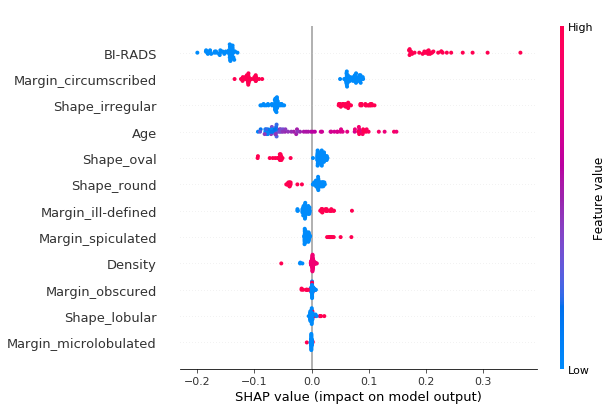

In [11]:
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(test_X)
# shape_values[1] is a list of probabilities giving prediction to the second class (aka malignant)
shap.summary_plot(shap_values[1], test_X)

# Neural Network Classifier

## Handle unbalance samples in training set
- In this case, the rateo (benign:malignant = 383:364) is no very off but it is a good pratice to always balance the sample size during training.
- Benign samples will be weighted a little more during training

In [12]:
sample_ratio = train_y.value_counts()
sample_ratio = sample_ratio.div(sample_ratio.max())
class_weights = (1/sample_ratio).to_dict()
# this dict will be feed into neural net during training
# 0: benign, 1:malignant
class_weights

{0: 1.0, 1: 1.0521978021978022}

## Define and train a Neural Network

In [0]:
def nn_model(input_shape):

    X_inputs = Input(shape=input_shape)

    # train_X is not standardized. 
    # Alternatively, use sklearn.preprocessing.Standardscaler before feeding into neural net
    X = BatchNormalization()(X_inputs)

    X = Dense(512, activation="relu")(X)
    X = BatchNormalization()(X)
    X = Dropout(0.7)(X)

    X = Dense(512, activation="relu")(X)
    X = BatchNormalization()(X)
    X = Dropout(0.7)(X)

    X = Dense(512, activation="relu")(X)
    X = BatchNormalization()(X)
    X = Dropout(0.7)(X)

    outputs = Dense(1, activation="sigmoid")(X)

    model = Model(inputs=X_inputs, outputs=outputs)

    return model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12)                48        
_________________________________________________________________
dense (Dense)                (None, 512)               6656      
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
______________________________________________

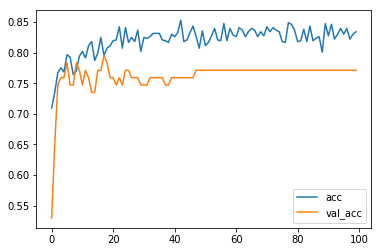

In [14]:
K.clear_session()

input_shape = train_X.shape[1]

# create an nn graph
nn_clf = nn_model(input_shape)
# print out nn summary
nn_clf.summary()

opt = Adam()
lr_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=10, min_delta=1e-4, cooldown=10, min_lr=1e-5, verbose=1)

nn_clf.compile(optimizer=opt, loss="binary_crossentropy", metrics=["acc"])

history = nn_clf.fit(
    # Keras does not take pandas DataFrames. Convert to array first.
    train_X.values,
    train_y.values,
    batch_size=16,
    epochs=100,
    verbose=0,
    callbacks=[lr_reduction],
    validation_data=(test_X, test_y),
    class_weight=class_weights,
    workers=5
)

plt.plot(history.history["acc"], label="acc")
plt.plot(history.history["val_acc"], label="val_acc")
plt.legend()
plt.show()

## Confution Matrix

              precision    recall  f1-score   support

      benign       0.79      0.77      0.78        44
   malignant       0.75      0.77      0.76        39

    accuracy                           0.77        83
   macro avg       0.77      0.77      0.77        83
weighted avg       0.77      0.77      0.77        83



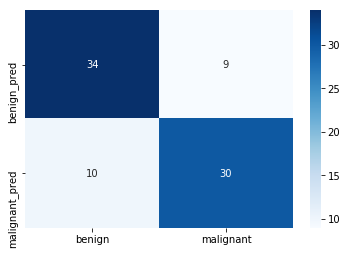

In [15]:
# make prediction. nn output array has shape [m, 1]. Squeeze into shape [m]
nn_pred_prob = nn_clf.predict(test_X).squeeze()
nn_pred = nn_pred_prob > 0.5

# make confusion matrix
nn_confusion = confusion_matrix(test_y, nn_pred)
nn_confusion = pd.DataFrame(nn_confusion.T, index=["benign_pred", "malignant_pred"], columns=["benign", "malignant"])

# put confusion matrix in heatmap
sns.heatmap(nn_confusion, annot=True, cmap="Blues")

# print out confusion matrix report
report = classification_report(test_y, nn_pred, labels=[0, 1], target_names=["benign", "malignant"])
print(report)

## ROC curve and AUC

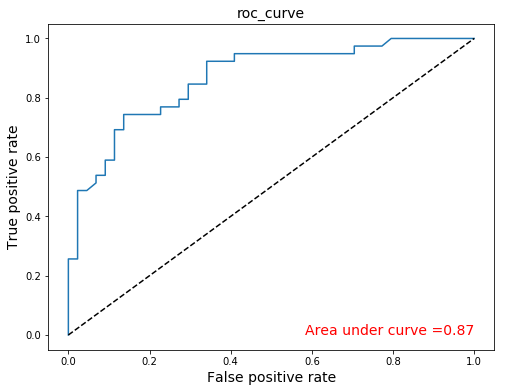

In [16]:
fpr, tpr, _ = roc_curve(test_y, nn_pred_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.plot((0,1), (0,1), linestyle="--", color="k")
plt.xlabel("False positive rate", size=14)
plt.ylabel("True positive rate", size=14)
plt.title("roc_curve", size=14)
plt.text(1, 0, f"Area under curve ={auc(fpr, tpr):.2f}", size=14, ha="right", color="r")
plt.show()

# Conclusion
- Random forest seems to perform a little better than neural network but both in close range.
- Margin and Shape together with BIDRAS give farily good predicting power
- Margin being circumscribed has a positive impact on benign prediction
- Shape being irregular is an strong indicator of having malignant mass